In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install geopandas matplotlib requests xarray rasterio rioxarray shapely


In [14]:
# Required packages for data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt

# Required for HTTP requests
import requests

# Required for working with multi-dimensional arrays and netCDF files
import xarray as xr
import os

# Required for spatial data manipulation
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping


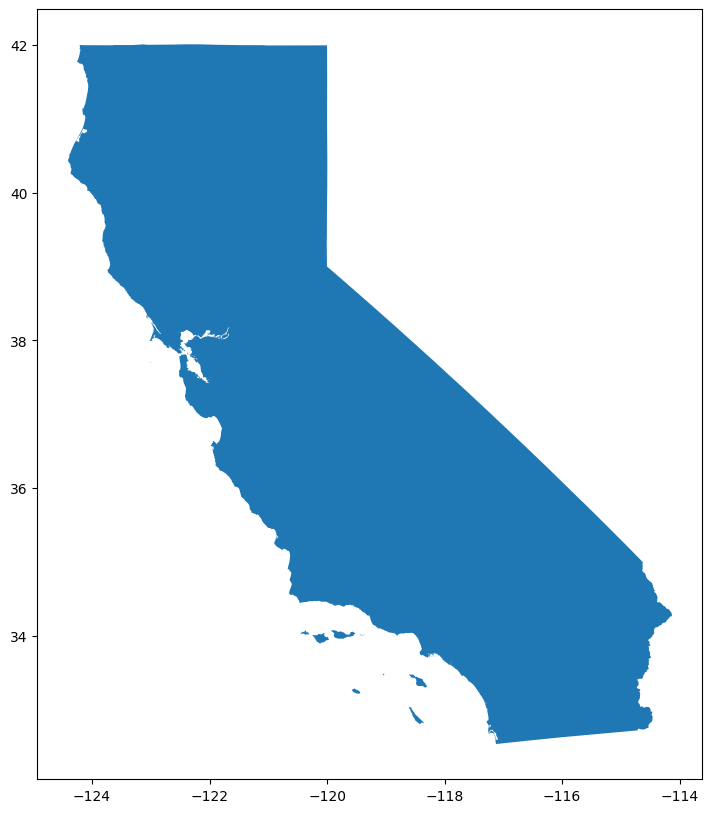

In [4]:
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax)
plt.show()


In [25]:
# Step 1: Extract dataset-specific links from the THREDDS Catalog
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Filter the links to include only those that point to dataset-specific pages with 'prcp_monttl_pr'
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/' + link['href'] for link in links if 'dataset=' in link['href'] and 'prcp_monttl_pr' in link['href']]


In [27]:
# Base URL for the THREDDS file server
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Initialize an empty list to store the xarray datasets
datasets = []

# Create a directory to store the downloaded NetCDF files
os.makedirs('netcdf_files', exist_ok=True)

# Loop through each dataset URL
for i, data_url in enumerate(dataset_links, start=1):
    # Extract the NetCDF file name from the URL
    nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

    # Construct the direct URL to the NetCDF file
    direct_url = base_url + nc_filename

    print(f"Downloading dataset {i}/{len(dataset_links)}: {direct_url}")

    # Download the dataset
    response = requests.get(direct_url)
    if response.status_code != 200:
        print(f"Failed to download dataset {i}: HTTP status code {response.status_code}")
        continue

    filename = f'netcdf_files/{nc_filename}'

    with open(filename, 'wb') as f:
        f.write(response.content)

    # Check if the file is downloaded correctly
    file_size = os.path.getsize(filename)
    print(f"File size of dataset {i}: {file_size} bytes")
    if file_size == 0:
        print(f"Failed to download dataset {i}: The file is empty")
        continue

    # Load the dataset and add it to the list
    try:
        ds = xr.open_dataset(filename)
        datasets.append(ds)
        print(f"Dataset {i} loaded successfully")
    except Exception as e:
        print(f"Failed to load dataset {i}: {str(e)}")

print("All datasets processed.")
print(f"Number of successfully loaded datasets: {len(datasets)}")


File size of dataset 1: 982605 bytes
Dataset 1 loaded successfully
File size of dataset 2: 967933 bytes
Dataset 2 loaded successfully
File size of dataset 3: 983677 bytes
Dataset 3 loaded successfully
File size of dataset 4: 980908 bytes
Dataset 4 loaded successfully
File size of dataset 5: 981045 bytes
Dataset 5 loaded successfully
File size of dataset 6: 983679 bytes
Dataset 6 loaded successfully
File size of dataset 7: 992616 bytes
Dataset 7 loaded successfully
File size of dataset 8: 982648 bytes
Dataset 8 loaded successfully
File size of dataset 9: 988343 bytes
Dataset 9 loaded successfully
File size of dataset 10: 988629 bytes
Dataset 10 loaded successfully
File size of dataset 11: 996859 bytes
Dataset 11 loaded successfully
File size of dataset 12: 989233 bytes
Dataset 12 loaded successfully
File size of dataset 13: 986692 bytes
Dataset 13 loaded successfully
File size of dataset 14: 990969 bytes
Dataset 14 loaded successfully
File size of dataset 15: 979410 bytes
Dataset 15 loa

In [30]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Assuming `ds` is the xarray Dataset you want to visualize
# Clip the data to the bounding box of California
california_bounds = california.bounds.iloc[0]

# Select the data within the bounding box
ds_clipped = ds.where((ds.lon >= california_bounds['minx']) & (ds.lon <= california_bounds['maxx']) &
                      (ds.lat >= california_bounds['miny']) & (ds.lat <= california_bounds['maxy']), drop=True)

# Assuming 'prcp' is the variable you want to plot
# You might need to adjust this depending on your specific dataset
variable_to_plot = 'prcp'

# Select the data for a specific time (e.g., the first time step)
ds_clipped = ds_clipped.isel(time=0)

# Plot the clipped data
ds_clipped[variable_to_plot].plot(x='lon', y='lat')
california.boundary.plot(ax=plt.gca(), linewidth=1, color='r')
plt.show()


ValueError: ignored

In [31]:
print(california.crs)


EPSG:4326


In [32]:
print('Longitude range in dataset:', ds.lon.min().values, ds.lon.max().values)
print('Latitude range in dataset:', ds.lat.min().values, ds.lat.max().values)


Longitude range in dataset: -67.98689 -64.125626
Latitude range in dataset: 16.850077 19.932451


In [33]:
print('California bounding box:', california_bounds)


California bounding box: minx   -124.415558
miny     32.530884
maxx   -114.129486
maxy     42.009830
Name: 4, dtype: float64


In [ ]:
!pip install matplotlib cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a new plot with PlateCarree projection (which is a simple geographic projection)
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and gridlines for better reference
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot the dataset
ds['prcp'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'shrink': 0.5})

# Show the plot
plt.show()
